In [2]:
import pystan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#We begin with creating stan models and sampling

In [3]:
gamma = """
data {
    real alpha;
    real beta;
}

generated quantities {
    real y = gamma_rng (alpha, beta);
}
"""
modelGamma = pystan.StanModel(model_code = gamma)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34cff2f9a3acdf6a269b23c7c115ebc3 NOW.


In [10]:
invGamma = """
data {
    real alpha;
    real beta;
}
generated quantities {
    real y = inv_gamma_rng(alpha, beta);
}
"""
modelInvGamma = pystan.StanModel(model_code = invGamma)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38e4fdc6b62b264ff1ae275d5daf76a1 NOW.


In [11]:
simData = {'alpha' : 5, 'beta' : 1}
sim_pcc_gamma = modelGamma.sampling(data = simData, algorithm = 'Fixed_param', iter = 1000)
paramsGamma = pd.DataFrame(sim_pcc_gamma.extract())
sim_pcc_inv_gamma = modelInvGamma.sampling(data = simData, algorithm = 'Fixed_param', iter = 1000)
paramsInvGamma = pd.DataFrame(sim_pcc_inv_gamma.extract())

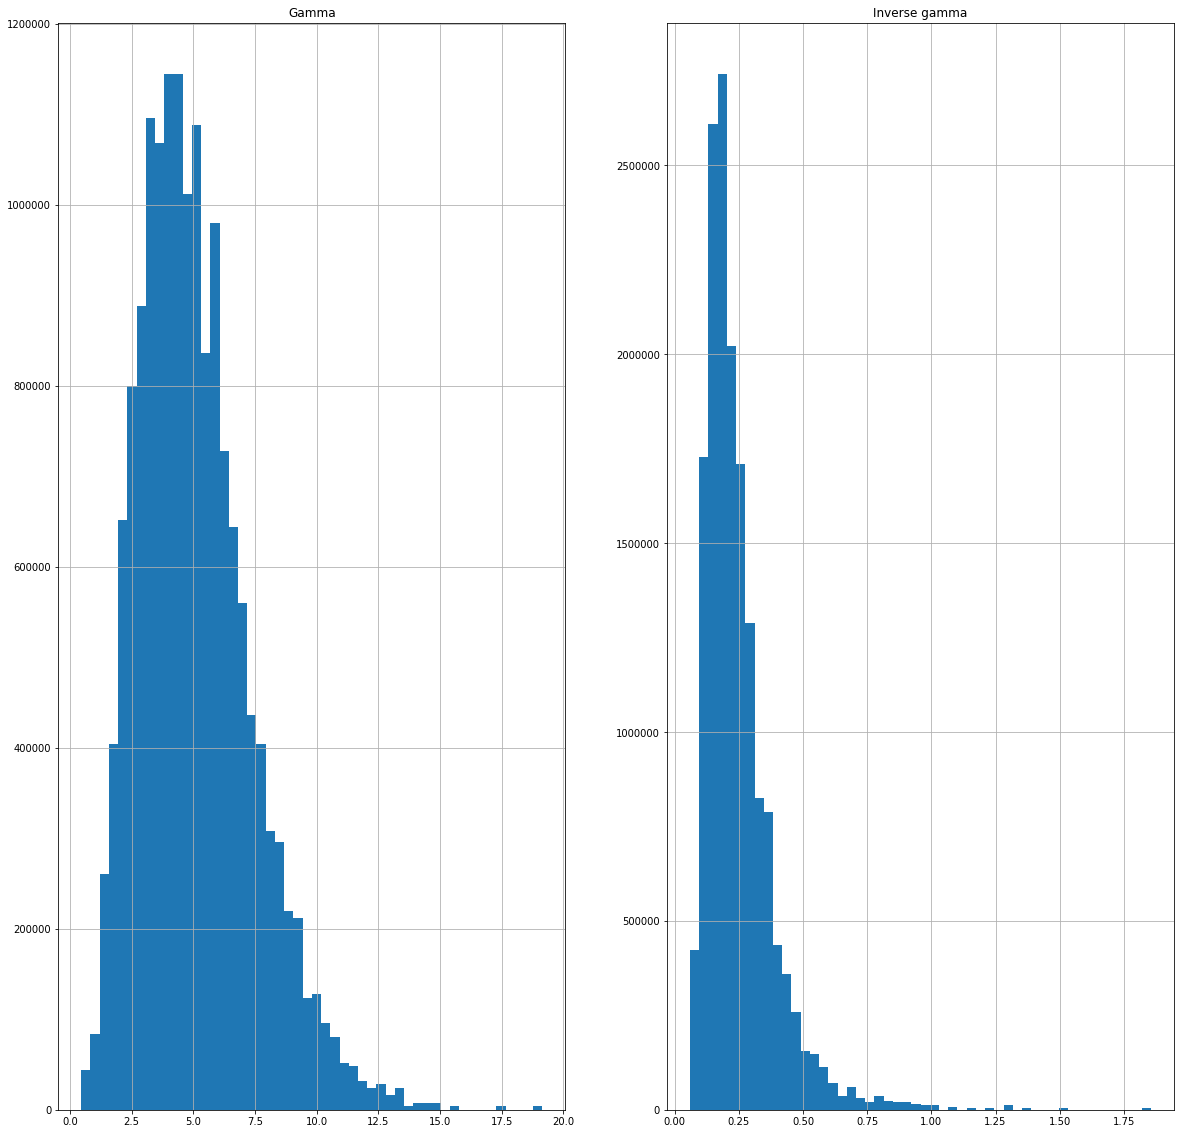

In [28]:
#We extract data to DataFrames and plot histograms
paramsGamma.columns = ['gamma', 'lp__']
paramsInvGamma.columns = ['invGamma', 'lp__']
params = paramsGamma.merge(paramsInvGamma)
params.drop('lp__', axis = 1, inplace = True)
plt.figure(figsize = [20, 20])
plt.subplot(1, 2, 1).set_title('Gamma')
plt.hist(params['gamma'], bins = 50)
plt.grid()
plt.subplot(1, 2, 2).set_title('Inverse gamma')
plt.hist(params['invGamma'], bins = 50)
plt.grid()
plt.show()

In [16]:
#Both distributions have infinite right-hand tails, but they decrease exponentially. 
#We now find values of alpha and beta for which 98% of probability is between 5 and 10.
gamma98 = """
functions {
    vector gammaUnknown (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        gammas[2] = gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        gammas[3] = exp(y[1])/exp(y[2]) - 7;
        return gammas;
    }
}
data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}
transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(gammaUnknown, y_guess, theta, x_r, x_i);
}
generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}
"""
modelGamma98 = pystan.StanModel(model_code = gamma98)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00389be0f7f9777d0014b213ea8ac566 NOW.


In [17]:
data = {'lowerBound': 5, 'upperBound': 10, 'alphaGuess': 8, 'betaGuess': 1, 'probGuess': 0.09}
sim_pcc_98 = modelGamma98.sampling(data = data, algorithm = 'Fixed_param', iter = 1)
print("alpha: {}, beta: {}".format(sim_pcc_98.extract()['alpha'][0], sim_pcc_98.extract()['beta'][0]))

alpha: 47.3650757384028, beta: 6.76643939120023


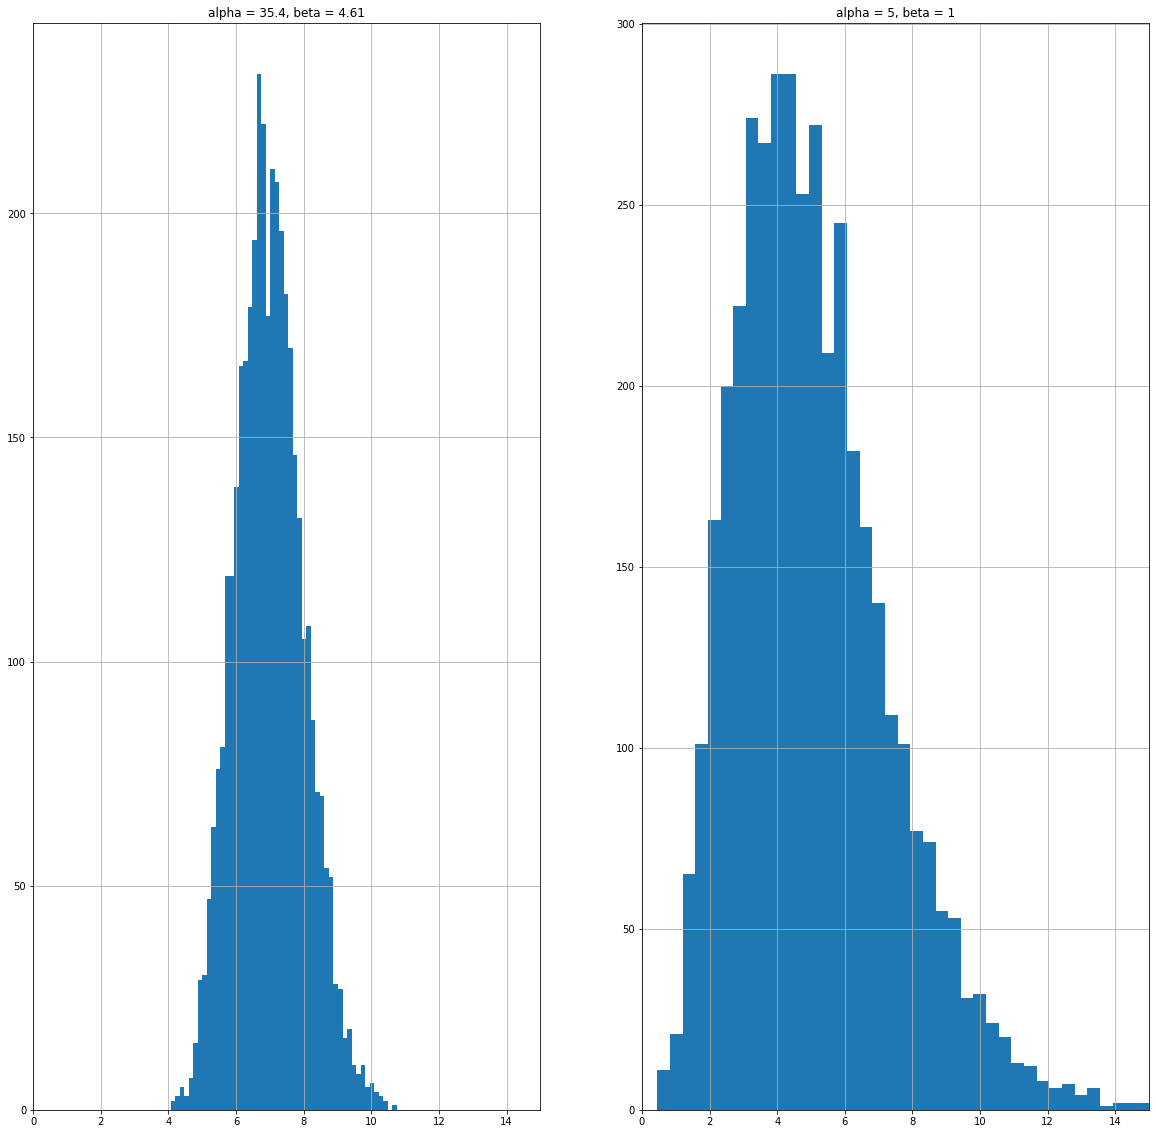

In [31]:
#We plot the histogram of gamma distribution with above parameters and compare it with the previous one.
simData = {'alpha' : 47.37, 'beta' : 6.77}
sim_pcc_gamma_98 = modelGamma.sampling(data = simData, algorithm = 'Fixed_param', iter = 1000)
paramsGamma98 = pd.DataFrame(sim_pcc_gamma_98.extract())
plt.figure(figsize = (20, 20))
plt.subplot(1, 2, 1).set_title('alpha = 35.4, beta = 4.61')
plt.hist(paramsGamma98['y'], bins = 50)
plt.xlim((0, 15))
plt.grid()
plt.subplot(1, 2, 2).set_title('alpha = 5, beta = 1')
plt.hist(paramsGamma['gamma'], bins = 50)
plt.xlim((0, 15))
plt.grid()
plt.show()

In [19]:
#We do the same for invGamma.
invGamma98 = """
functions {
    vector gammaUnknown (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] gammas;
        gammas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        gammas[2] = inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        gammas[3] = exp(y[1])/exp(y[2]) - 7;
        return gammas;
    }
}
data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}
transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(gammaUnknown, y_guess, theta, x_r, x_i);
}
generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}
"""
modelInvGamma98 = pystan.StanModel(model_code = invGamma98)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a8b0b7e50c46b9f719dcade0bcf7b6e NOW.


In [24]:
data = {'lowerBound': 5, 'upperBound': 10, 'alphaGuess': 18, 'betaGuess': 3, 'probGuess': 0.05}
sim_pcc_98 = modelInvGamma98.sampling(data = data, algorithm = 'Fixed_param', iter = 1)
print("alpha: {}, beta: {}".format(sim_pcc_98.extract()['alpha'][0], sim_pcc_98.extract()['beta'][0]))

ValueError: Exception: Exception: inv_gamma_cdf: Shape parameter is nan, but must be > 0!  (in 'unknown file name' at line 5)
  (in 'unknown file name' at line 24)


In [ ]:
#Finding parameters for inverse gamma distribution failed. Several sets of y_guess were tried, but to no avail.